In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
train = pd.read_csv("../Data/train.csv").drop(columns="Unnamed: 0")
test = pd.read_csv("../Data/test.csv").drop(columns="Unnamed: 0")
train.head()

,date,905270,921795,904261,905261,916328,923024,936365,902355,912215,...,9889RL,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
0,1990-01-02,22.75,12.63,30.00,29.61,3.8736,11.00,4.1250,24.50,58.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-03,22.56,12.57,31.50,29.37,3.8876,11.00,4.0000,24.50,57.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-01-04,22.38,12.41,32.25,28.89,3.8806,11.38,3.9375,24.63,57.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-01-05,21.81,12.60,32.13,28.41,3.8387,11.50,3.8125,24.75,57.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-01-08,22.25,12.49,32.13,29.13,3.8387,11.50,3.8125,25.00,57.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train["date"] = pd.to_datetime(train["date"], format="%Y-%m-%d")
test["date"] = pd.to_datetime(test["date"], format="%Y-%m-%d")

In [7]:
# Running linear regression on a sample stock

sample = train[["date", "936365"]]
sample["936365_lag1"] = train["936365"].shift(-1)
sample

,date,936365,936365_lag1
0,1990-01-02,4.1250,4.0000
1,1990-01-03,4.0000,3.9375
2,1990-01-04,3.9375,3.8125
3,1990-01-05,3.8125,3.8125
4,1990-01-08,3.8125,3.8750
...,...,...,...
6326,2015-02-09,3.0400,3.0400
6327,2015-02-10,3.0400,3.0700
6328,2015-02-11,3.0700,3.1200
6329,2015-02-12,3.1200,3.1500


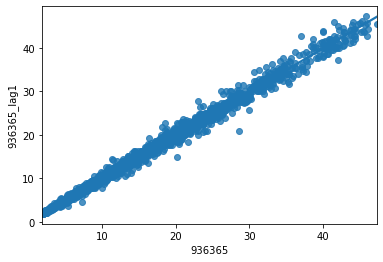

In [8]:
sns.regplot(data=sample, x="936365", y="936365_lag1")

In [9]:
sample["936365"].isna().value_counts()

False    6331
Name: 936365, dtype: int64

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
lag = 1
new_df = sample.iloc[:-1, :]
model.fit(X=new_df[["936365"]], y=new_df["936365_lag1"])

LinearRegression()

In [11]:
print("Line formula for 936365: \ncurrent price = " + str(model.intercept_) + " + " +
      str(model.coef_[0]) + " * prev price")

Line formula for 936365: 
current price = 0.028297530216166322 + 0.9974971975060474 * prev price


In [12]:
# Predicting for a single stock
import datetime

total_predictions = pd.DataFrame()

next_days = 10
lag = 1
stock_predictions = []
for day in range(next_days):
    model = LinearRegression()
    new_df = sample.iloc[:-1, :]
    model.fit(X=new_df[["936365"]], y=new_df["936365_lag1"])
    current_price = sample[["936365"]].iloc[-1][0]
    next_pred = model.predict(pd.DataFrame([[current_price]]))[0]
    next_day = sample[["date"]].iloc[-1][0] + datetime.timedelta(days=1)
    sample["936365_lag1"].fillna(next_pred, inplace=True)
    sample = sample.append(pd.DataFrame({"date": [next_day], 
                                         "936365": [next_pred], 
                                         "936365_lag1": [np.nan]})).reset_index(drop=True)
    stock_predictions.append(next_pred)
    
total_predictions["936365"] = stock_predictions
total_predictions

,936365
0,3.170414
1,3.190776
2,3.211088
3,3.231349
4,3.251559
5,3.271718
6,3.291827
7,3.311886
8,3.331895
9,3.351853


In [13]:
# Filtering for only listed stocks
listed_stocks = train.loc[:, ~train.iloc[-1].isnull()].columns
listed_stocks

Index(['date', '905270', '921795', '904261', '905261', '916328', '923024',
       '936365', '902355', '912215',
       ...
       '311917', '69568X', '543755', '77463M', '29235J', '131745', '69487D',
       '68157P', '9110RA', '292703'],
      dtype='object', length=1215)

In [14]:
# Parameters for prediction model
total_predictions = pd.DataFrame()

next_days = 30
lag = 1
num_stocks = 99

In [15]:
# Running predictions for all stocks
count = 1
for stock in listed_stocks[1:num_stocks + 1]:
    sample = train[["date", stock]].dropna()
    sample[stock + "_lag1"] = train[stock].shift(-1)
    stock_predictions = []
    for day in range(next_days):
        model = LinearRegression()
        new_df = sample.iloc[:-1, :]
        model.fit(X=new_df[[stock]], y=new_df[stock + "_lag1"])
        current_price = sample[[stock]].iloc[-1][0]
        next_pred = model.predict(pd.DataFrame([[current_price]]))[0]
        next_day = sample[["date"]].iloc[-1][0] + datetime.timedelta(days=1)
        sample[stock + "_lag1"].fillna(next_pred, inplace=True)
        sample = sample.append(pd.DataFrame({"date": [next_day], 
                                             stock: [next_pred], 
                                             stock + "_lag1": [np.nan]})).reset_index(drop=True)
        stock_predictions.append(next_pred)
    total_predictions[stock] = stock_predictions
    print(count, end=" ")
    count += 1

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [16]:
total_predictions

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,906839,906196,902242,905024,904803,916790,912455,902245,912060,916125
0,53.807069,11.396142,29.682764,20.358874,46.094613,30.000514,3.170414,57.937995,68.123061,52.310420,...,7.399929,73.503107,59.638340,112.777483,47.130445,102.074090,0.011298,79.810992,85.882319,109.014399
1,53.804142,11.402273,29.675561,20.367739,46.099226,30.001029,3.190776,57.935991,68.116141,52.310839,...,7.399858,73.506213,59.606730,112.774967,47.130891,102.088180,0.022581,79.811983,85.884637,109.028797
2,53.801217,11.408394,29.668391,20.376593,46.103838,30.001543,3.211088,57.933988,68.109240,52.311258,...,7.399787,73.509319,59.575167,112.772452,47.131336,102.102270,0.033849,79.812973,85.886954,109.043195
3,53.798296,11.414505,29.661254,20.385437,46.108451,30.002056,3.231349,57.931987,68.102356,52.311677,...,7.399716,73.512423,59.543653,112.769937,47.131780,102.116359,0.045103,79.813963,85.889270,109.057593
4,53.795379,11.420605,29.654149,20.394271,46.113062,30.002570,3.251559,57.929988,68.095492,52.312096,...,7.399645,73.515527,59.512187,112.767424,47.132224,102.130449,0.056342,79.814952,85.891584,109.071991
5,53.792464,11.426696,29.647076,20.403095,46.117674,30.003083,3.271718,57.927991,68.088645,52.312515,...,7.399575,73.518629,59.480769,112.764911,47.132669,102.144539,0.067566,79.815939,85.893897,109.086388
6,53.789553,11.432776,29.640035,20.411908,46.122285,30.003596,3.291827,57.925994,68.081818,52.312933,...,7.399505,73.521731,59.449400,112.762399,47.133112,102.158629,0.078776,79.816926,85.896210,109.100785
7,53.786644,11.438846,29.633026,20.420712,46.126896,30.004108,3.311886,57.924000,68.075008,52.313351,...,7.399434,73.524832,59.418079,112.759887,47.133556,102.172718,0.089971,79.817912,85.898521,109.115182
8,53.783739,11.444905,29.626050,20.429506,46.131506,30.004621,3.331895,57.922007,68.068216,52.313769,...,7.399364,73.527932,59.386805,112.757376,47.133999,102.186808,0.101152,79.818898,85.900830,109.129579
9,53.780838,11.450955,29.619104,20.438289,46.136116,30.005133,3.351853,57.920015,68.061443,52.314187,...,7.399294,73.531031,59.355580,112.754867,47.134442,102.200898,0.112318,79.819882,85.903139,109.143975


In [17]:
true_values = test.drop(columns="date").loc[:next_days - 1, total_predictions.columns]

In [18]:
true_values

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,906839,906196,902242,905024,904803,916790,912455,902245,912060,916125
0,53.81,11.39,29.69,20.35,46.41,30.0,3.110,57.94,68.13,52.31,...,7.4,73.5,60.10,112.40,47.13,101.16,0.0,79.81,85.88,108.86
1,53.81,11.39,29.69,20.35,46.41,30.0,3.080,57.94,68.13,52.31,...,7.4,73.5,59.37,110.44,47.13,101.45,0.0,79.81,85.88,109.77
2,53.81,11.39,29.69,20.35,46.61,30.0,3.055,57.94,68.13,52.31,...,7.4,73.5,59.23,108.35,47.13,100.96,0.0,79.81,85.88,109.28
3,53.81,11.39,29.69,20.35,47.48,30.0,3.060,57.94,68.13,52.31,...,7.4,73.5,59.80,108.60,47.13,100.16,0.0,79.81,85.88,108.94
4,53.81,11.39,29.69,20.35,47.32,30.0,3.060,57.94,68.13,52.31,...,7.4,73.5,59.35,107.86,47.13,99.35,0.0,79.81,85.88,109.73
5,53.81,11.39,29.69,20.35,47.47,30.0,3.110,57.94,68.13,52.31,...,7.4,73.5,60.82,107.96,47.13,100.37,0.0,79.81,85.88,109.37
6,53.81,11.39,29.69,20.35,47.40,30.0,3.100,57.94,68.13,52.31,...,7.4,73.5,61.14,108.58,47.13,100.12,0.0,79.81,85.88,108.99
7,53.81,11.39,29.69,20.35,47.61,30.0,3.080,57.94,68.13,52.31,...,7.4,73.5,61.58,107.06,47.13,100.66,0.0,79.81,85.88,109.10
8,53.81,11.39,29.69,20.35,47.37,30.0,3.110,57.94,68.13,52.31,...,7.4,73.5,61.28,106.68,47.13,100.45,0.0,79.81,85.88,108.64
9,53.81,11.39,29.69,20.35,47.22,30.0,3.210,57.94,68.13,52.31,...,7.4,73.5,61.77,105.90,47.13,101.46,0.0,79.81,85.88,109.92


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE: " + str(mean_squared_error(y_true=true_values, y_pred=total_predictions)))
print("MAE: " + str(mean_absolute_error(y_true=true_values, y_pred=total_predictions)))
print("R2: " + str(r2_score(y_true=true_values, y_pred=total_predictions)))

MSE: 3.8503079526279134
MAE: 0.8753401902037243
R2: -9.481235554950482e+26
